In [1]:
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [2]:
fig_scale = 1.#2./3.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time
import json

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform

In [4]:
plt.rcParams['font.size'] = 14

In [5]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[GpuDevice(id=0), GpuDevice(id=1), GpuDevice(id=2), GpuDevice(id=3)]


# Process Data

In [6]:
c_df, r_df, d_df = transform.IRD(min_confirmed=0, min_recovered=0, min_deaths=20)
c_df.columns = pd.to_datetime(c_df.columns)
d_df.columns = pd.to_datetime(d_df.columns)

[267, 255, 130]


In [7]:
t_df, h_df, w_df, uv_df = transform.weather(update=False)

In [8]:
d_df = d_df[d_df.columns[:-55]]

In [9]:
d_df

2020-01-22  2020-01-23  2020-01-24  2020-01-25  2020-01-26  \
Country/Region                                                               
Afghanistan              0           0           0           0           0   
Albania                  0           0           0           0           0   
Algeria                  0           0           0           0           0   
Andorra                  0           0           0           0           0   
Argentina                0           0           0           0           0   
...                    ...         ...         ...         ...         ...   
Yemen                    0           0           0           0           0   
Tajikistan               0           0           0           0           0   
Australia                0           0           0           0           0   
Canada                   0           0           0           0           0   
China                   17          18          26          42          56   

                2020-01-27  2020-01-28  2020-01-29  2020-01-30  2020-01-31  \
Country/Region                                                               
Afghanistan              0           0           0           0           0   
Albania                  0           0           0           0           0   
Algeria                  0           0           0           0           0   
Andorra                  0           0           0           0           0   
Argentina                0           0           0           0           0   
...                    ...         ...         ...         ...         ...   
Yemen                    0           0           0           0           0   
Tajikistan               0           0           0           0           0   
Australia                0           0           0           0           0   
Canada                   0           0           0           0           0   
China                   82         131         133         171         213   

                ...  2020-04-13  2020-04-14  2020-04-15  2020-04-16  \
Country/Region  ...                                                   
Afghanistan     ...          21          23          25          30   
Albania         ...          23          24          25          26   
Algeria         ...         313         326         336         348   
Andorra         ...          29          31          33          33   
Argentina       ...          97         102         111         115   
...             ...         ...         ...         ...         ...   
Yemen           ...           0           0           0           0   
Tajikistan      ...           0           0           0           0   
Australia       ...          61          62          63          63   
Canada          ...         780         900        1007        1258   
China           ...        3341        3341        3342        3342   

                2020-04-17  2020-04-18  2020-04-19  2020-04-20  2020-04-21  \
Country/Region                                                               
Afghanistan             30          30          33          36          36   
Albania                 26          26          26          26          26   
Algeria                364         367         375         384         392   
Andorra                 35          35          36          37          37   
Argentina              123         129         132         136         147   
...                    ...         ...         ...         ...         ...   
Yemen                    0           0           0           0           0   
Tajikistan               0           0           0           0           0   
Australia               66          67          67          67          67   
Canada                1355        1400        1564        1726        1909   
China                 4632        4632        4632        4632        4632   

                2020-04-22  
Country/Region    

In [10]:
tests_df = pd.read_csv('../data/test_rate/test_rate_processed.csv', index_col='Country/Region')
tests_df.columns = pd.to_datetime(tests_df.columns)

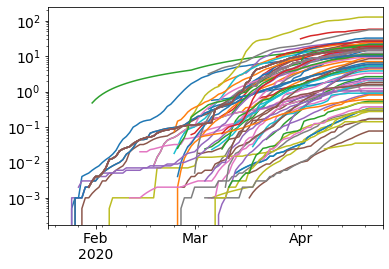

In [11]:
tests_df.T.plot(legend=False, logy=True)

In [12]:
all_countries = tests_df.index.intersection(d_df.index)

In [13]:
len(all_countries)

74

In [14]:
cases = {}
deaths = {}
temps = {}
hums = {}
uv = {}
testsp1k = {}
start_days = np.argmax((d_df.values>3),axis=1)
end_days = np.argmax((d_df.values>1000), axis=1)
for i, country in enumerate(d_df.index):
    climate_delay = 28    # days between infection and death
    if start_days[i]<climate_delay:
        climate_delay = start_days[i]
    if country not in all_countries:
        continue
    if len(d_df.T[country].values[start_days[i]:])>10 and start_days[i]>0:
        if end_days[i]>0:
            time_slice = slice(start_days[i]-climate_delay, end_days[i]-climate_delay)
            temps[country] = np.nanmean(t_df.T[country].values[time_slice])
            hums[country] = np.nanmean(h_df.T[country].values[time_slice])
            uv[country] = np.nanmean(uv_df.T[country].values[time_slice])
            cases[country] = c_df[d_df.columns[start_days[i]:end_days[i]]].T[country].values
            deaths[country] = d_df[d_df.columns[start_days[i]:end_days[i]]].T[country].values
            testsp1k[country] = tests_df[d_df.columns[start_days[i]:end_days[i]]].T[country].values
            if np.isnan(np.nanmax(testsp1k[country])):
                del deaths[country]
                del testsp1k[country]
        else:
            temps[country] = np.nanmean(t_df.T[country].values[start_days[i]-climate_delay:])
            hums[country] = np.nanmean(h_df.T[country].values[start_days[i]-climate_delay:])
            uv[country] = np.nanmean(uv_df.T[country].values[start_days[i]-climate_delay:])
            cases[country] = c_df[d_df.columns[start_days[i]:]].T[country].values
            deaths[country] = d_df[d_df.columns[start_days[i]:]].T[country].values
            testsp1k[country] = tests_df[d_df.columns[start_days[i]:]].T[country].values
            if np.isnan(np.nanmax(testsp1k[country])):
                del deaths[country]
                del testsp1k[country]

In [15]:
len(deaths)

64

In [16]:
samples = {}
with h5py.File('../data/nb_samples/4.1.0.1_STEP_EXP_Independent_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]
countries = onp.loadtxt('../data/nb_samples/4.1.0.1_STEP_EXP_Independent_countries.txt', 
                        delimiter='|', dtype=str)[:,0]
t0 = np.mean(samples['t0'], axis=0)

t0_dict = dict(zip(countries, t0.astype(np.int32)))

In [17]:
# Ecuador shows to have greater than 100% positive rate. MORE POSITIVES than TESTS
all_countries = list(set(deaths.keys()).intersection(countries[t0>10]) - set(['Ecuador']))

In [18]:
len(all_countries)

43

In [19]:
pops = transform.population()
posp1k = {}
posrate = {}
for c in deaths.keys():
    posp1k[c] = cases[c][-1]/pops[c].values*1000
    posrate[c] = posp1k[c]/np.nanmean(testsp1k[c])*100

[267, 255, 267]
Number of unmatched regions : 74
Population data saved @ /data/COVID-19/covid19/data/population/populations.csv


In [20]:
bcg_cov_est = json.load(open('BCG_Coverage_Estimates.json', 'r'))

In [21]:
print(f'Missing BCG Coverage for : {set(all_countries)-set(bcg_cov_est.keys())}')
all_countries = list(set(all_countries).intersection(bcg_cov_est.keys()))

Missing BCG Coverage for : {'Bolivia'}


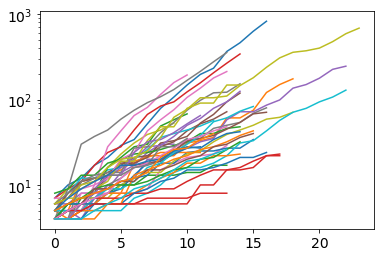

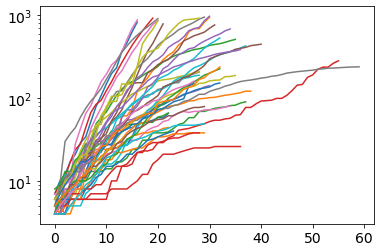

In [22]:
for c in all_countries:
    plt.semilogy(deaths[c][:t0_dict[c]])
plt.figure()
for c in all_countries:
    plt.semilogy(deaths[c])

In [23]:
len(all_countries)

42

In [24]:
blood_df = pd.read_csv('../data/blood/blood_type.csv', index_col='Country')

aus = ['Australia / New South Wales']
canada = ['Canada / Alberta', 'Canada / British Columbia', 
          'Canada / Ontario', 'Canada / Quebec']
china = ['China / Henan', 'China / Hubei']
DEAD = ['Czechia', 'Congo (Kinshasa)', 'Korea, South', 
        'Luxembourg', 'North Macedonia', 'Moldova', 'US']
BLOOD = ['Czech Republic', 'Democratic Republic of the Congo', 'Korea', 
         'Luxemburg', 'Macedonia', 'Republic of Moldova', 'United States']
aplus = {}
for c in blood_df.T:
    if c in d_df.index:
        aplus[c] = blood_df['A+'][c]
    elif (c in BLOOD):
        idx = np.where(onp.array(BLOOD)==c)[0][0]
        aplus[DEAD[idx]] = blood_df['A+'][c]
        
for c in aus:
    aplus[c] = aplus['Australia']
for c in canada:
    aplus[c] = aplus['Canada']
for c in china:
    aplus[c] = aplus['China']

In [25]:
set(all_countries) - set(aplus.keys())

{'Panama', 'Tunisia'}

In [26]:
all_countries = list(set(all_countries).intersection(aplus.keys()))

In [27]:
theta = {}
for c in all_countries:
    theta[c] = list(onp.array([bcg_cov_est[c], temps[c], hums[c], np.nanmax(testsp1k[c]), posrate[c][0], aplus[c], uv[c]]))

In [28]:
len(theta), len(theta['US'])

(40, 7)

In [29]:
# import json

In [30]:
# json.dump(theta, open('../data/THETA.json', 'w'))

In [31]:
theta = {}
for c in all_countries:
    theta[c] = np.array([bcg_cov_est[c], temps[c], hums[c], np.nanmax(testsp1k[c]), posrate[c][0], uv[c]])

In [32]:
len(theta), len(theta['US'])

(40, 6)

# Bayesian Model

In [33]:
def normalHP(name, mean, std, N_child):

    # Group mean
    grp_mean = numpyro.sample(str(name)+'_grp_mean', dist.Normal(mean, std))
    # Group variance
    grp_sigma = numpyro.sample(str(name)+'_grp_sigma', dist.HalfNormal(std))
    # Individual param
    ind = numpyro.sample(str(name)+'_ind', 
                         dist.TransformedDistribution(dist.Normal(0.0*np.ones(N_child), 1.0*np.ones(N_child)), 
                                                      dist.transforms.AffineTransform(grp_mean, grp_sigma)))
#     ind = numpyro.sample(str(name)+'_ind', dist.Normal(grp_mean*np.ones(N_child), grp_sigma*np.ones(N_child)))
    
    return ind

In [43]:
def model():
    
    N = len(all_countries)
    N_theta = len(theta[list(theta.keys())[0]])
    
#     Di = normalHP('Di', 7.0, 3.0, N)
#     GR = normalHP('GR', 1.2, 0.2, N)
    Di = normalHP('Di', 7.0, 5.0, N)
    GR = normalHP('GR', 1.2, 0.5, N)
    
    # Coefficients / Weights
#     W = numpyro.sample('W', dist.Normal(0.0*np.ones(N_theta), 0.01*np.ones(N_theta)))
    W = numpyro.sample('W', dist.Normal(0.0*np.ones(N_theta), 0.1*np.ones(N_theta)))

    # Create likelihood for each country    
    for i, country in enumerate(all_countries):
        dead = deaths[country][:t0_dict[country]]
        t = np.arange(len(dead))
        correction = np.dot(W, theta[country])
        prediction = Di[i]*(GR[i]+correction)**t
        numpyro.sample(country, dist.Poisson(prediction), # Exponential regression
                       obs=dead)

In [44]:
N = len(all_countries)
N_theta = len(theta[list(theta.keys())[0]])

scale = 0.5

# init_params = {'Di_grp_mean': 7.0*np.ones((N_chains, 1)) + 3.0*scale*onp.random.randn(N_chains, 1),
#                'GR_grp_mean': 1.2*np.ones((N_chains, 1)) + 0.2*scale*onp.random.randn(N_chains, 1),
#                'Di_grp_sigma': 0.0*np.ones((N_chains, 1)) + 0.1*np.abs(scale*onp.random.randn(N_chains, 1)),
#                'GR_grp_sigma': 0.0*np.ones((N_chains, 1)) + 0.1*np.abs(scale*onp.random.randn(N_chains, 1)),
#                'Di_ind': 7.0*np.ones((N_chains, N)) + 3.0*scale*onp.random.randn(N_chains, N),
#                'GR_ind': 1.2*np.ones((N_chains, N)) + 0.2*scale*onp.random.randn(N_chains, N),
#                'W': 0.0*np.ones((N_chains, N_theta)) + 0.01*scale*onp.random.randn(N_chains, N_theta)
#               }
init_params = {'Di_grp_mean': 7.0*np.ones((N_chains, 1)) + 5.0*scale*onp.random.randn(N_chains, 1),
               'GR_grp_mean': 1.2*np.ones((N_chains, 1)) + 0.5*scale*onp.random.randn(N_chains, 1),
               'Di_grp_sigma': 0.0*np.ones((N_chains, 1)) + 3.0*np.abs(scale*onp.random.randn(N_chains, 1)),
               'GR_grp_sigma': 0.0*np.ones((N_chains, 1)) + 0.3*np.abs(scale*onp.random.randn(N_chains, 1)),
               'Di_ind': 7.0*np.ones((N_chains, N)) + 5.0*scale*onp.random.randn(N_chains, N),
               'GR_ind': 1.2*np.ones((N_chains, N)) + 0.5*scale*onp.random.randn(N_chains, N),
               'W': 0.0*np.ones((N_chains, N_theta)) + 0.1*scale*onp.random.randn(N_chains, N_theta)
              }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=5000, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [45]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(f'Time taken to compile model and draw samples : {time()-s} s')

Time taken to compile model and draw samples : 14464.772602558136 s


In [46]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/4.1.1.11.0_EXCL_BLOOD_WIDE_MultiVariate_Regression_samples.h5', 'w') as fp:
    for key in samples.keys():
        fp[key] = samples[key]
    fp['potential_energy'] = mcmc.get_extra_fields()['potential_energy']
    fp['countries'] = [c.encode() for c in all_countries]
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
 Di_grp_mean[0]      7.02      4.57      7.79      0.56     11.94       nan 9158720.00
Di_grp_sigma[0]      7.55      9.82      2.04      1.57     24.54       nan 78720736.00
      Di_ind[0]     73.27     93.67     22.66     12.47    235.31      2.00  50466.68
      Di_ind[1]     34.81     27.43     21.31     14.56     82.09      2.00  84539.52
      Di_ind[2]     66.34     81.04     26.50      6.48    205.87      2.00  31422.73
      Di_ind[3]     42.77     43.94     20.43     11.59    118.60      2.00 135705.72
      Di_ind[4]     82.73    107.28     27.34      8.23    268.03      2.00  40537.77
      Di_ind[5]     57.32     67.75     22.59      9.79    174.31      2.00  69202.17
      Di_ind[6]     42.27     47.09     19.10      7.65    123.21      2.00 146522.64
      Di_ind[7]     57.60     71.03     18.26     13.42    180.46      2.00  57099.96
      Di_ind[8]     37.17     37.89     17.55     

In [53]:
samples = {}
with h5py.File('../data/nb_samples/4.1.1.11.0_EXCL_BLOOD_MultiVariate_Regression_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]

(-1802, -1790)

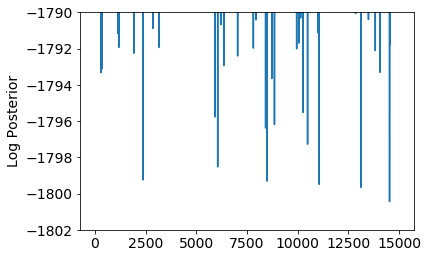

In [59]:
plt.plot(-samples['potential_energy'][:15000])
plt.ylabel('Log Posterior')
plt.ylim(-1802, -1790)

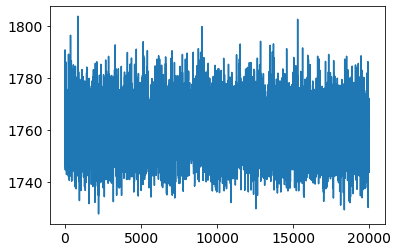

In [30]:
plt.plot(samples['potential_energy'])

In [36]:
float(np.min(samples['potential_energy'])), float(np.mean(samples['potential_energy'])), float(np.max(samples['potential_energy']))

(1727.729248046875, 1759.9232177734375, 1803.607421875)

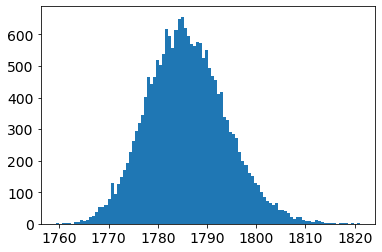

In [41]:
plt.hist(samples['potential_energy'], bins=100);

In [34]:
all_samples = np.concatenate([samples[key] for key in samples if key not in ['countries', 'potential_energy']], axis=1)

In [35]:
all_samples.shape

(20000, 90)

In [36]:
import corner

In [ ]:
plt.rcParams['font.size'] = 10
param_data = ['BCG Coverage', 'Temperature', 'Relative Humidity','A+ Blood Type']
param_name = [r'$\theta_0$', r'$\theta_1$', r'$\theta_2$',
              r'$\theta_3$']
fig = corner.corner(all_samples[::20], #labels=param_name,
                       quantiles=[0.16, 0.5, 0.84], bins=30, title_fmt='.5f',
                       show_titles=True, title_kwargs={"fontsize": 12})

# line = sns.kdeplot(samples['W'][:10,0], color='k')
# fig.legend(handles=[line for _ in range(N_theta)], 
#            labels=[f'{param_name[i]} := {param_data[i]}' for i in range(N_theta)])

plt.savefig('../plots/4.1.1.8_BCG_Climate_Test_Blood_Corner_Plot_Mega.png', dpi=200)
plt.rcParams['font.size'] = 14

In [31]:
len(all_countries)

40

In [32]:
np.sum([len(deaths[key]) for key in all_countries])

DeviceArray(1327, dtype=int32)

In [43]:
THETA = np.array([theta[c] for c in theta])

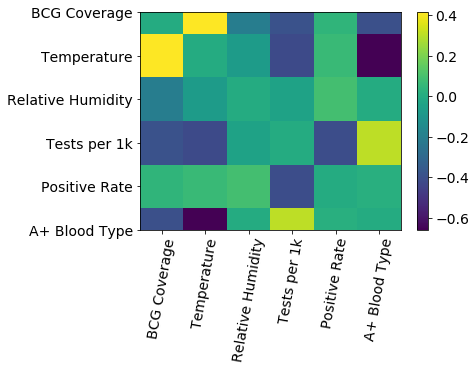

In [71]:
# plt.figure(figsize=(7,10))
cov = np.cov(THETA.T)
corr = cov/np.sqrt((np.diag(cov)[None,:]*np.diag(cov)[:,None]))
corr -= np.eye(len(corr))
plt.imshow(corr)
plt.colorbar()
plt.xticks(np.arange(len(corr)), ['BCG Coverage', 'Temperature', 
                                  'Relative Humidity', 'Tests per 1k', 
                                  'Positive Rate', 'A+ Blood Type'],
          rotation=80)

plt.yticks(np.arange(len(corr)), ['BCG Coverage', 'Temperature', 
                                  'Relative Humidity', 'Tests per 1k', 
                                  'Positive Rate', 'A+ Blood Type'],
          rotation=0);

In [1]:
# plt.figure(figsize=(7,10))
# cov = np.cov(samples['W'])
# cov.shape
# corr = cov/np.sqrt((np.diag(cov)[None,:]*np.diag(cov)[:,None]))
# corr -= np.eye(len(corr))
# plt.imshow(corr)
# plt.colorbar()
# plt.xticks(np.arange(len(corr)), ['BCG Coverage', 'Temperature', 
#                                   'Relative Humidity', 'Tests per 1k', 
#                                   'Positive Rate', 'A+ Blood Type'],
#           rotation=80)

# plt.yticks(np.arange(len(corr)), ['BCG Coverage', 'Temperature', 
#                                   'Relative Humidity', 'Tests per 1k', 
#                                   'Positive Rate', 'A+ Blood Type'],
#           rotation=0);

In [44]:
THETA.shape

(40, 6)

# Trace Plots

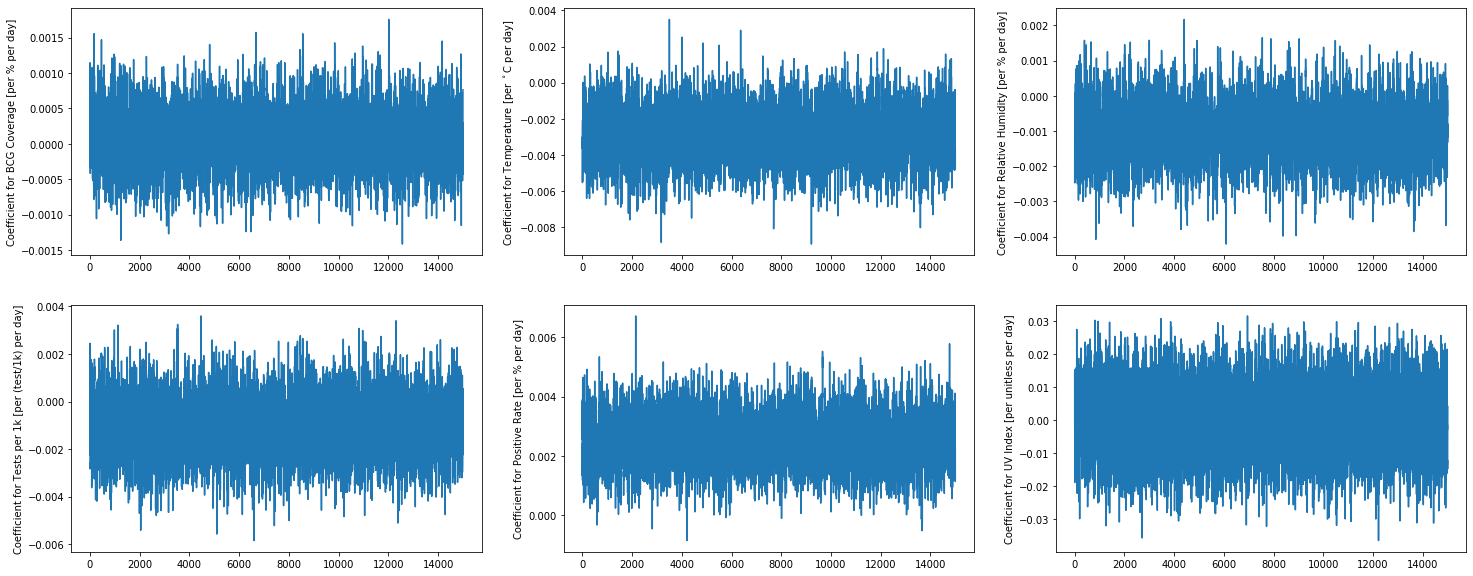

In [39]:
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(2, 3, figsize=(25, 10))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate', 'UV Index']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%', 'unitless']
for i in range(N_theta):
    a[i].plot(samples['W'][:15000,i])
    a[i].set_ylabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')
plt.rcParams['font.size'] = 14

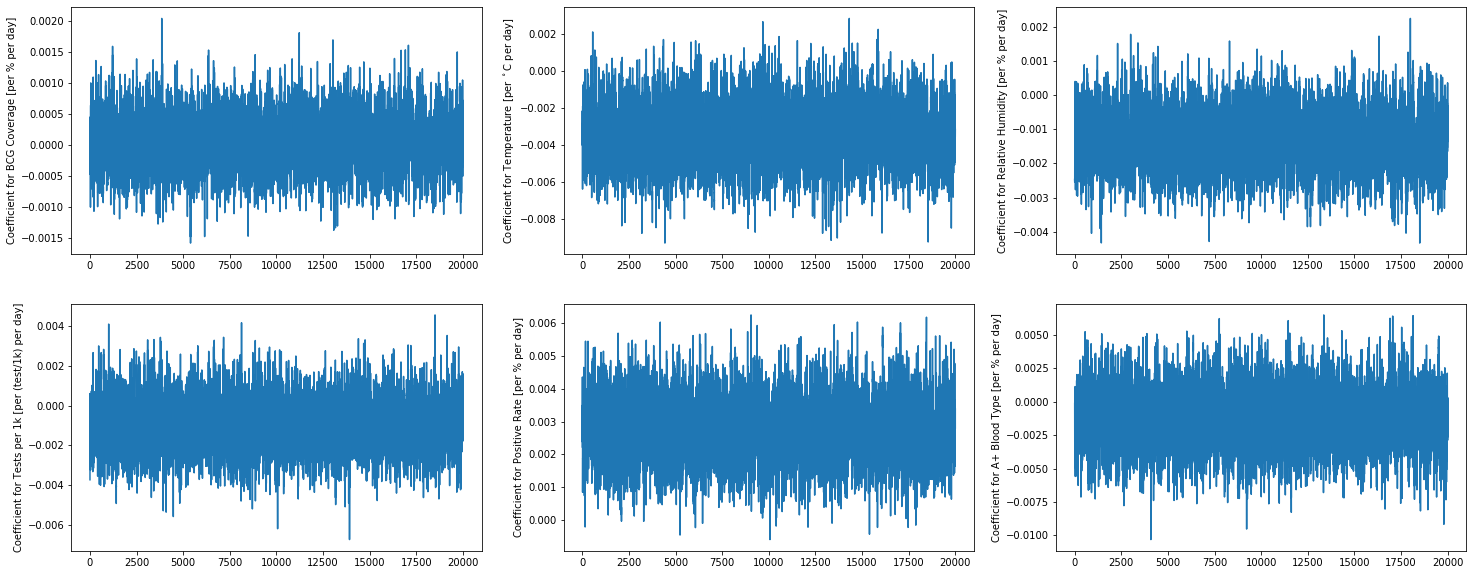

In [47]:
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(2, 3, figsize=(25, 10))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate', 'A+ Blood Type']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%', '%']
for i in range(N_theta):
    a[i].plot(samples['W'][:,i])
    a[i].set_ylabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')
plt.rcParams['font.size'] = 14

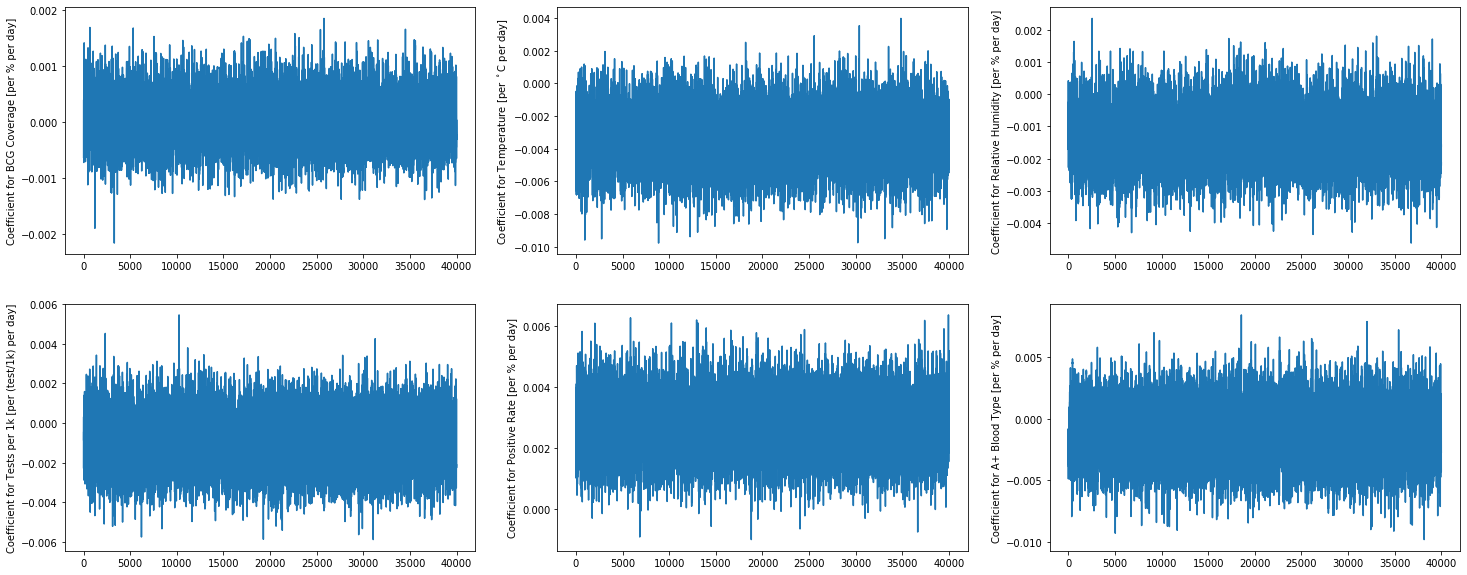

In [55]:
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(2, 3, figsize=(25, 10))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate', 'A+ Blood Type']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%', '%']
for i in range(N_theta):
    a[i].plot(samples['W'][:,i])
    a[i].set_ylabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')
plt.rcParams['font.size'] = 14

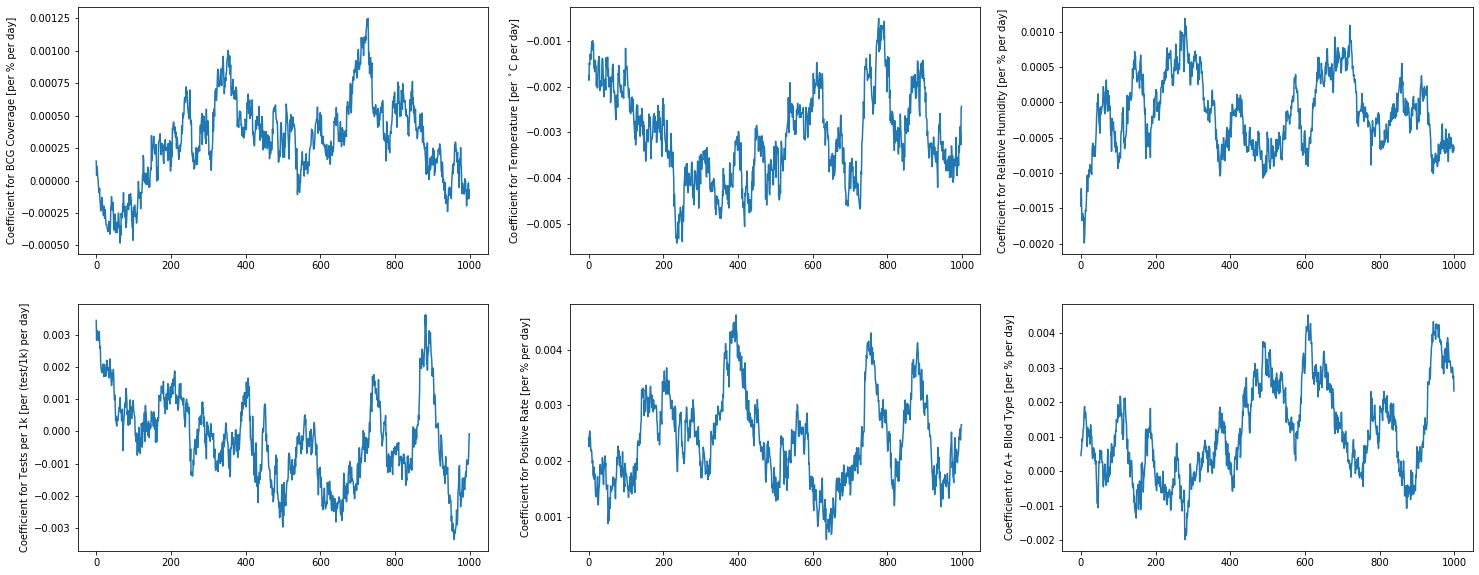

In [39]:
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(2, 3, figsize=(25, 10))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate', 'A+ Blood Type']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%', '%']
for i in range(N_theta):
    a[i].plot(samples['W'][:,i])
    a[i].set_ylabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')
plt.rcParams['font.size'] = 14

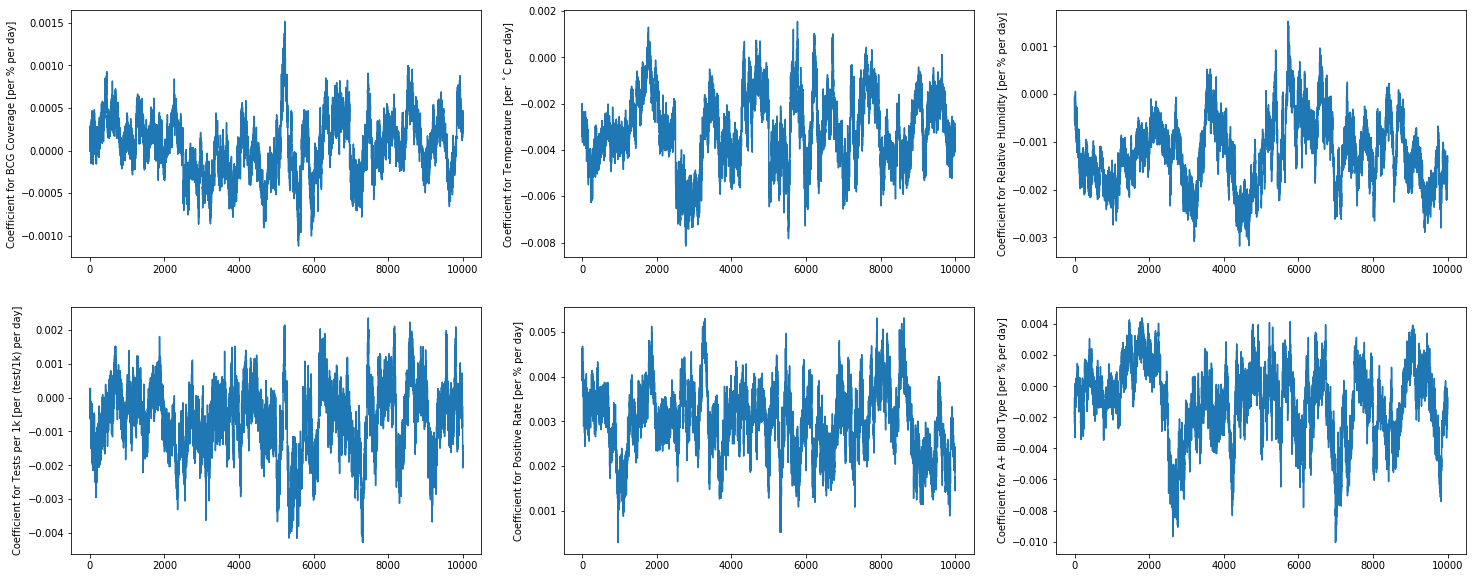

In [34]:
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(2, 3, figsize=(25, 10))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate', 'A+ Blood Type']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%', '%']
for i in range(N_theta):
    a[i].plot(samples['W'][:,i])
    a[i].set_ylabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')
plt.rcParams['font.size'] = 14

In [39]:
good_samples = np.where(samples['W'][:,0]>-0.006)[0]

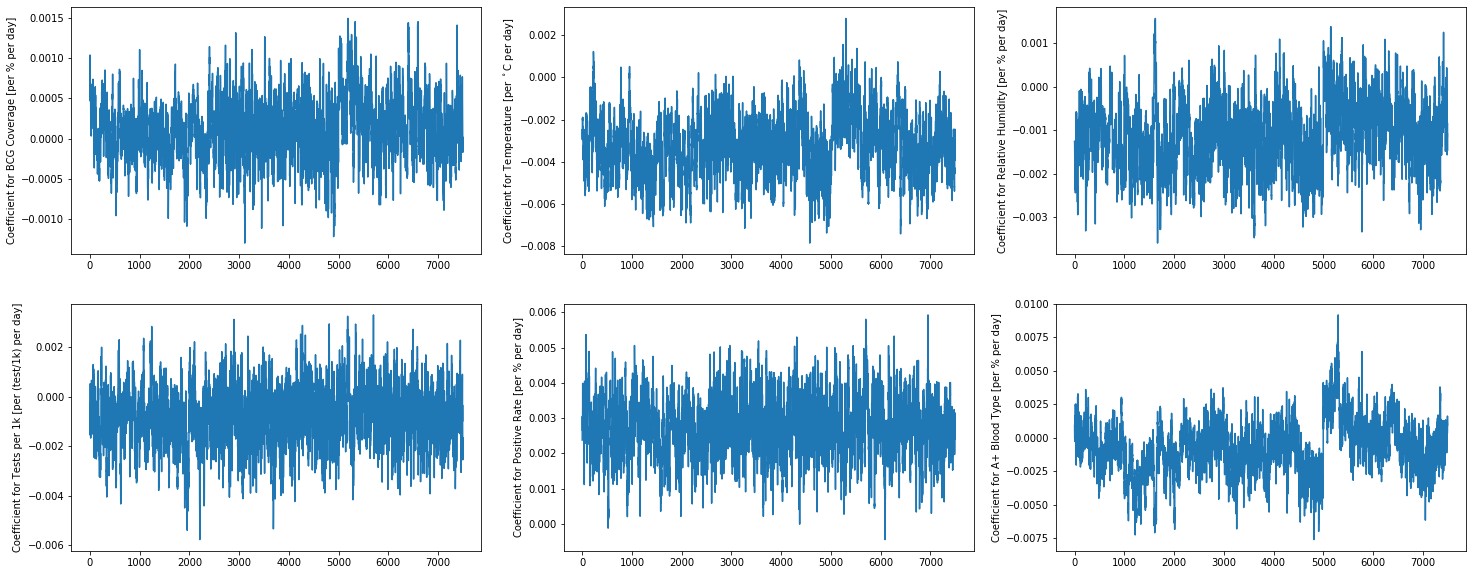

In [43]:
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(2, 3, figsize=(25, 10))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate', 'A+ Blood Type']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%', '%']
for i in range(N_theta):
    a[i].plot(samples['W'][good_samples,i])
    a[i].set_ylabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')
plt.rcParams['font.size'] = 14

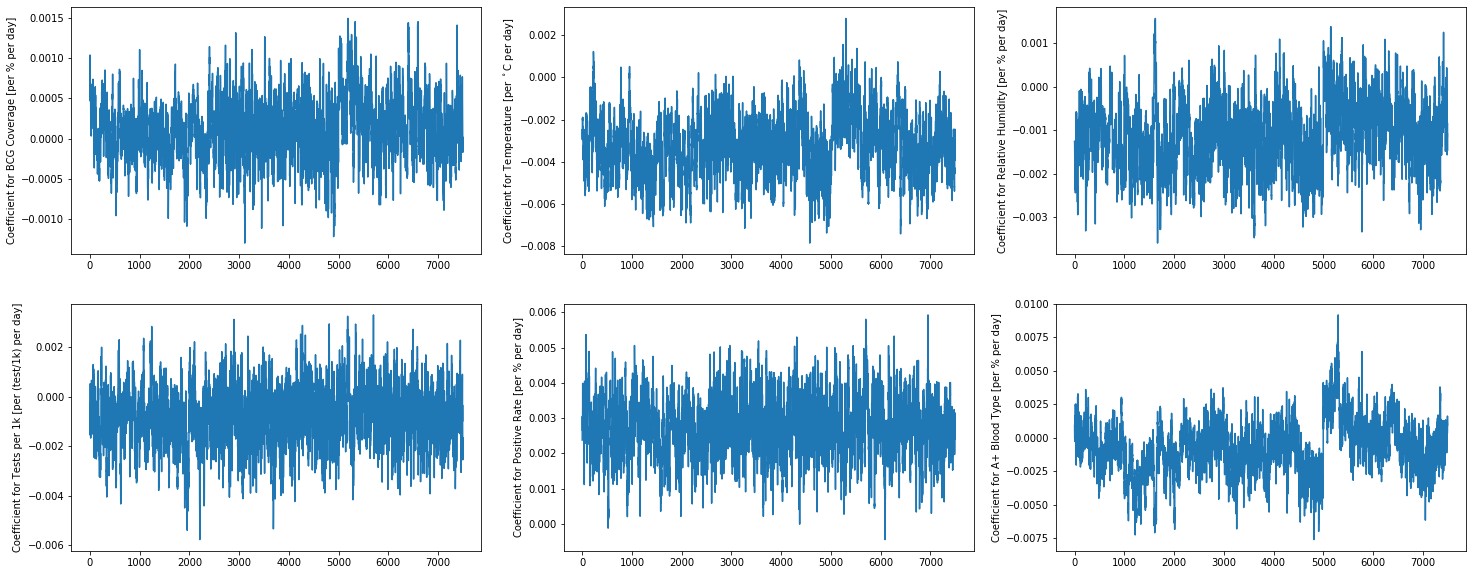

In [43]:
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(2, 3, figsize=(25, 10))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate', 'A+ Blood Type']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%', '%']
for i in range(N_theta):
    a[i].plot(samples['W'][good_samples,i])
    a[i].set_ylabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')
plt.rcParams['font.size'] = 14

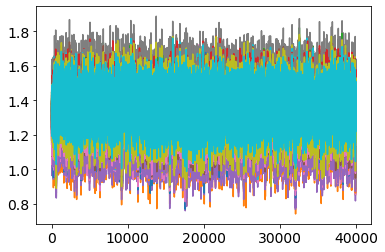

In [35]:
plt.plot(samples['GR_ind']);

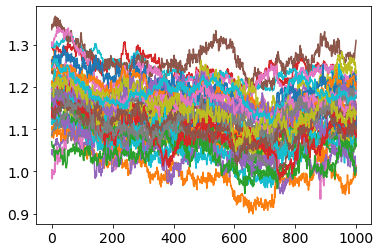

In [36]:
plt.plot(samples['GR_ind']);

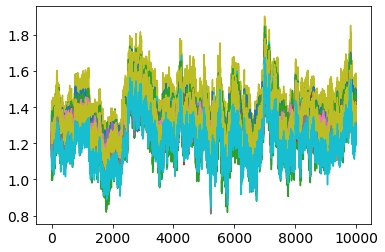

In [35]:
plt.plot(samples['GR_ind']);

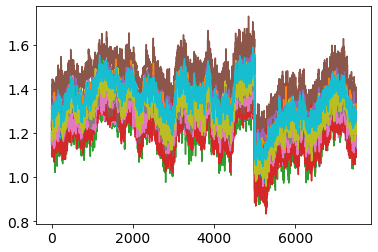

In [41]:
plt.plot(samples['GR_ind'][good_samples]);

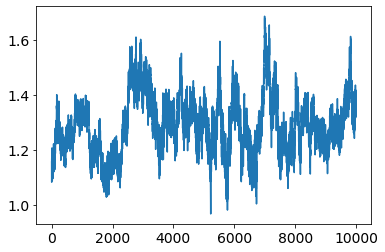

In [36]:
plt.plot(samples['GR_grp_mean'])

# Parameter Marginals

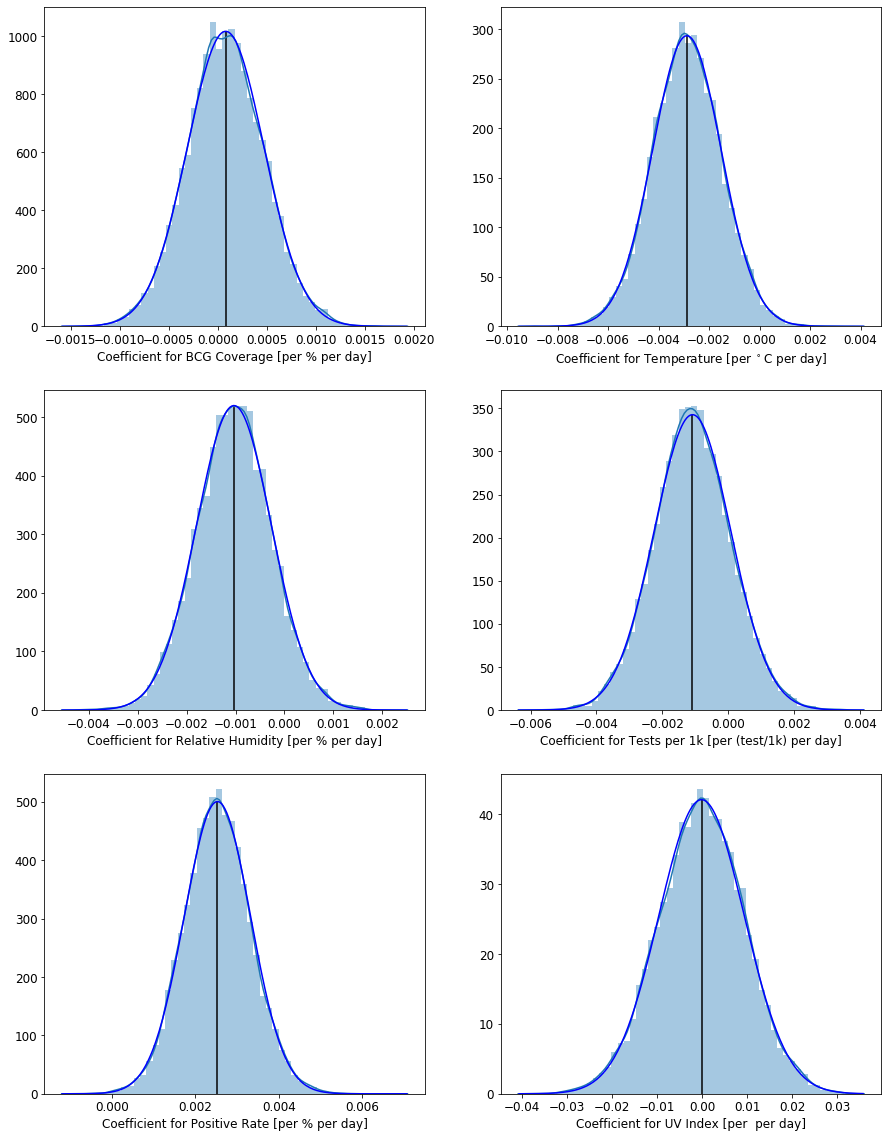

In [42]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(3, 2, figsize=(15, 20))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate', 'UV Index']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%', '']
for i in range(N_theta):
    sns.distplot(samples['W'][:15000,i], bins=50, fit=norm, ax = a[i],
                 fit_kws={'color':'blue'}, color='tab:blue', label=param_name[i])
    a[i].vlines(np.mean(samples['W'][:15000,i]), 0, norm.pdf(np.mean(samples['W'][:15000,i]), *norm.fit(samples['W'][:15000,i])))
    a[i].set_xlabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')

plt.rcParams['font.size'] = 14

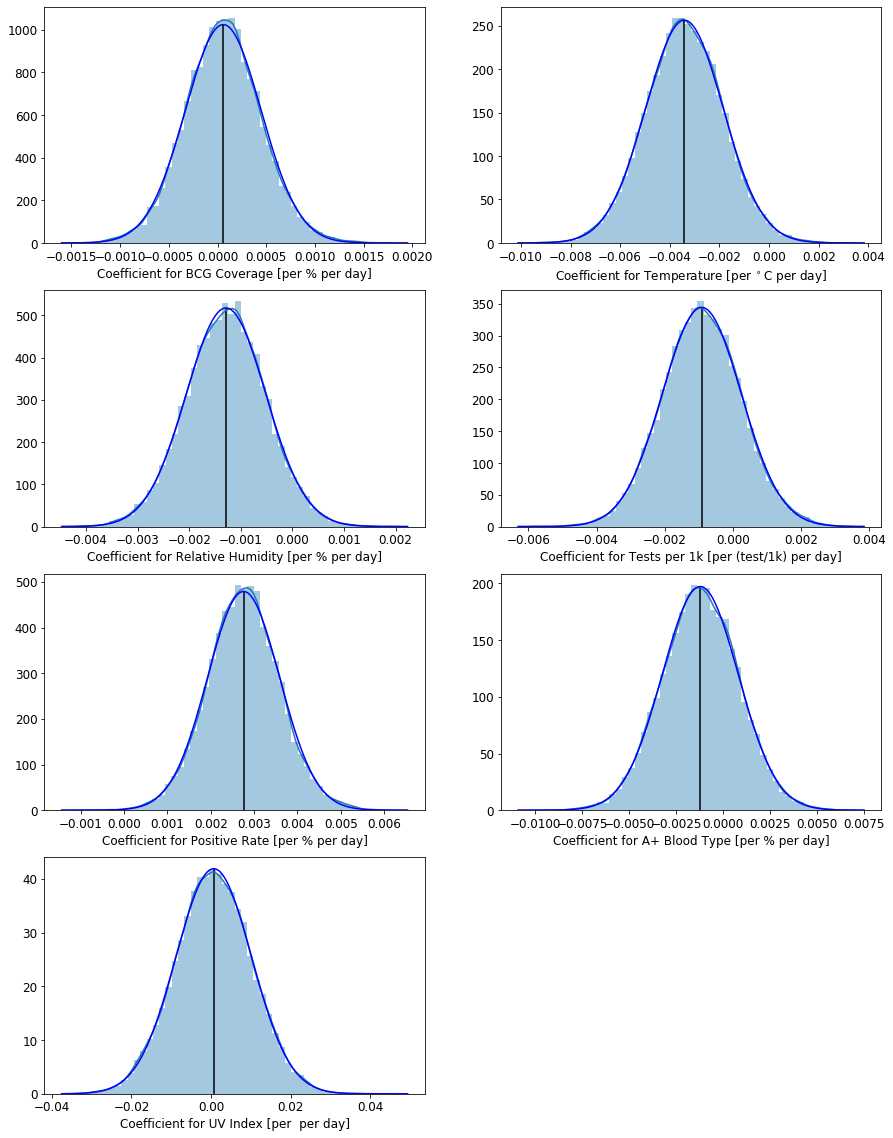

In [43]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(3, 2, figsize=(15, 20))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate', 'A+ Blood Type', 'UV Index']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%', '%', '']
for i in range(N_theta):
    sns.distplot(samples['W'][:,i], bins=50, fit=norm, ax = a[i],
                 fit_kws={'color':'blue'}, color='tab:blue', label=param_name[i])
    a[i].vlines(np.mean(samples['W'][:,i]), 0, norm.pdf(np.mean(samples['W'][:,i]), *norm.fit(samples['W'][:,i])))
    a[i].set_xlabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')

a[-1].set_axis_off()
plt.rcParams['font.size'] = 14

In [92]:
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 
              'Tests per 1k', 'Positive Rate', 'A+ Blood Type']
coeff_df = pd.DataFrame(samples['W'][:10000], columns=param_name) 

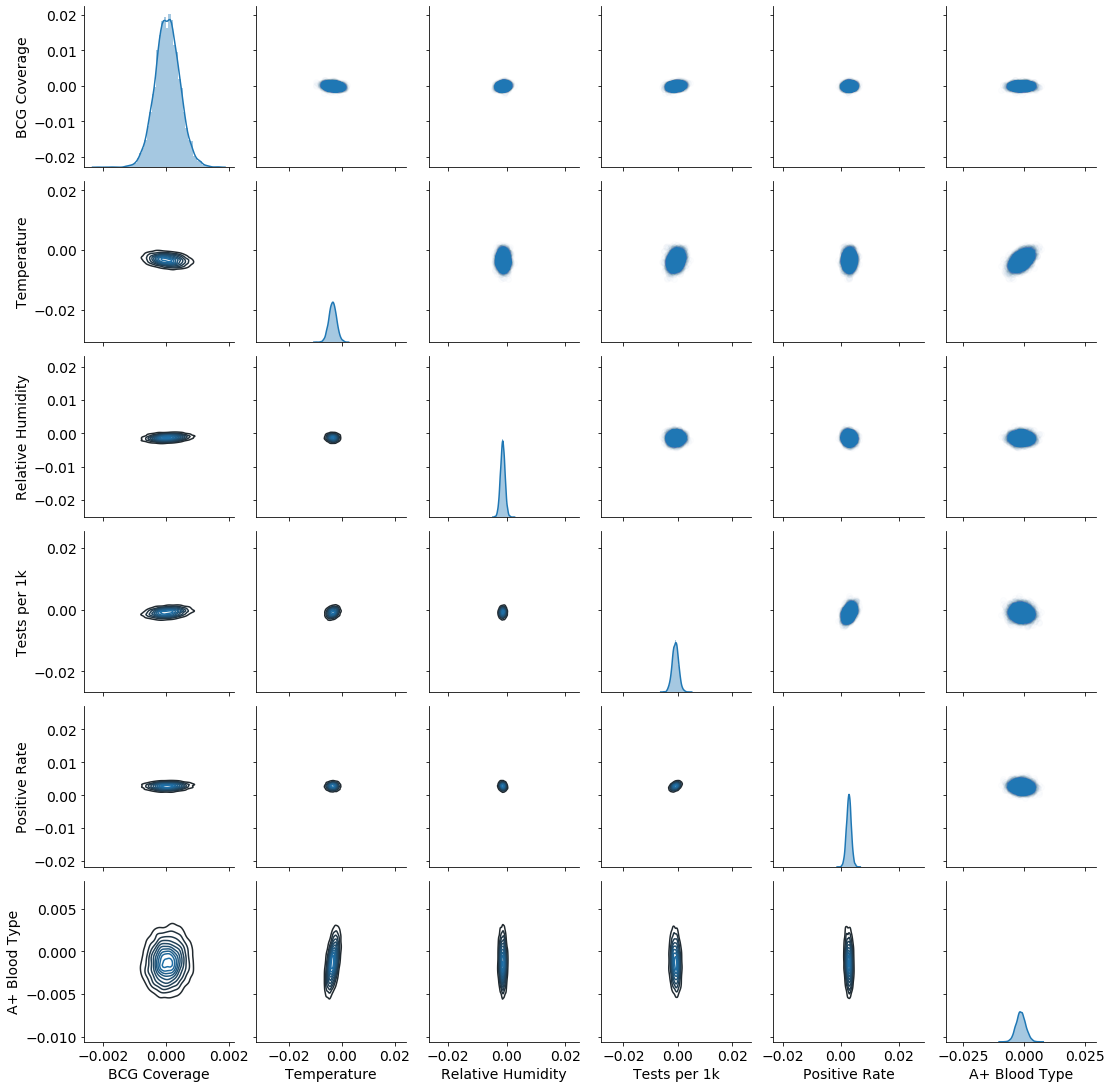

In [93]:
g = sns.PairGrid(coeff_df)
g.map_upper(plt.scatter, alpha=0.01)
g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot, lw=3, legend=False);
g.map_diag(sns.distplot)

In [163]:
np.abs(np.mean(samples['W'], axis=0)/np.std(samples['W'], axis=0))

DeviceArray([0.10949621, 2.2567582 , 1.6751995 , 0.80147463, 3.3130841 ,
             0.6230385 ], dtype=float32)

In [161]:
list(zip(np.mean(samples['W'], axis=0), np.std(samples['W'], axis=0)))

[(4.2403386e-05, 0.00038725897),
 (-0.0033650969, 0.0014911207),
 (-0.0012965329, 0.00077395746),
 (-0.00093372806, 0.0011650125),
 (0.0027515374, 0.0008305063),
 (-0.0012630529, 0.0020272466)]

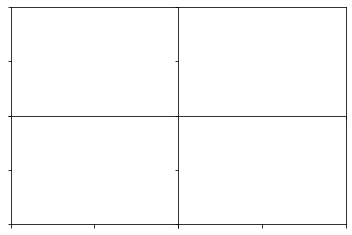

In [95]:
fig, ax = plt.subplots(2,2)

for a in ax.flatten():
    a.set_xticklabels([])
    a.set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [124]:
%env JAX_ENABLE_X64=True

env: JAX_ENABLE_X64=True


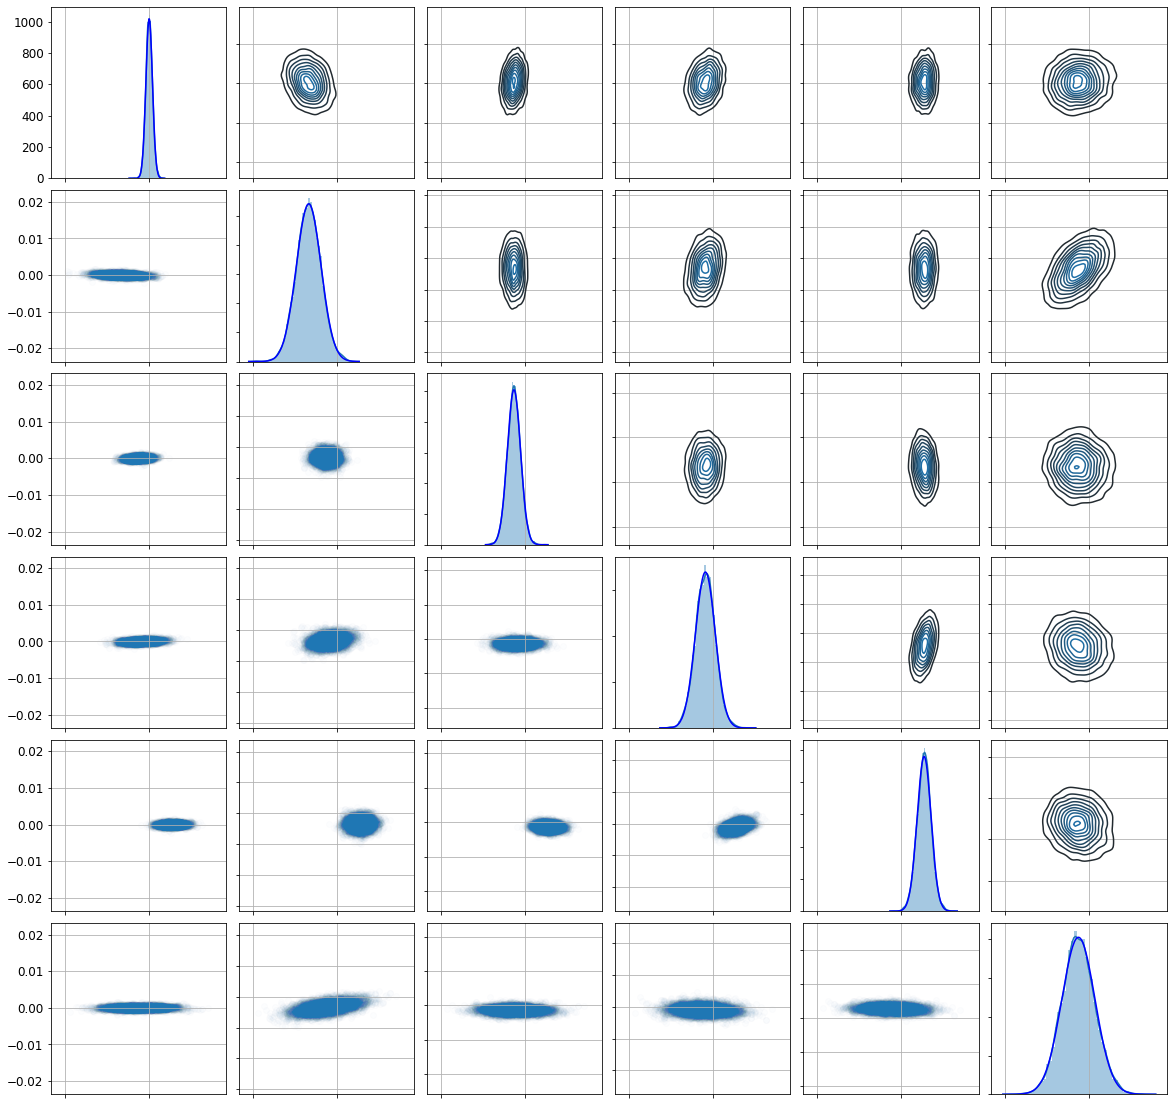

In [159]:
N_samples = 10000
plt.rcParams['font.size'] = 12
plot_space = 0.07
fig, ax = plt.subplots(6, 6, figsize=(20,20), sharex=True)
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 
              'Tests per 1k', 'Positive Rate', 'A+ Blood Type']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%', '%']

# Diagnonal
for i in range(N_theta):
    sns.distplot(samples['W'][:N_samples,i], bins=50, fit=norm, ax = ax[i,i],
                 fit_kws={'color':'blue'}, color='tab:blue', label=param_name[i])
    ax[i,i].grid(axis='x')
        
idx = np.triu_indices(N_theta, 1)

# Upper Triangle
for i, a in enumerate(ax[idx[0], idx[1]]):
    a.grid()
    sns.kdeplot(samples['W'][:N_samples,idx[1][i]], samples['W'][:N_samples,idx[0][i]], ax=a)
#     ax[i,i].set_yticklabels([])

# Lower Triangle
for i, a in enumerate(ax[idx[1], idx[0]]):
    a.grid()
    a.scatter(samples['W'][:N_samples,idx[1][i]], samples['W'][:N_samples,idx[0][i]], 
              color='tab:blue', alpha=0.01)
#     sns.kdeplot(samples['W'][:N_samples,idx[1][i]], samples['W'][:N_samples,idx[0][i]], ax=a)


# ax[0,0].set_yticklabels(ax[1,0].get_yticks())

for a in ax[:,1:].flatten():
    a.set_yticklabels([])
for a in ax[:-1,:].flatten():
    a.set_xticklabels([])

    
plt.subplots_adjust(wspace=plot_space, hspace=plot_space)
plt.rcParams['font.size'] = 14

In [50]:
import corner

In [ ]:
from matplotlib

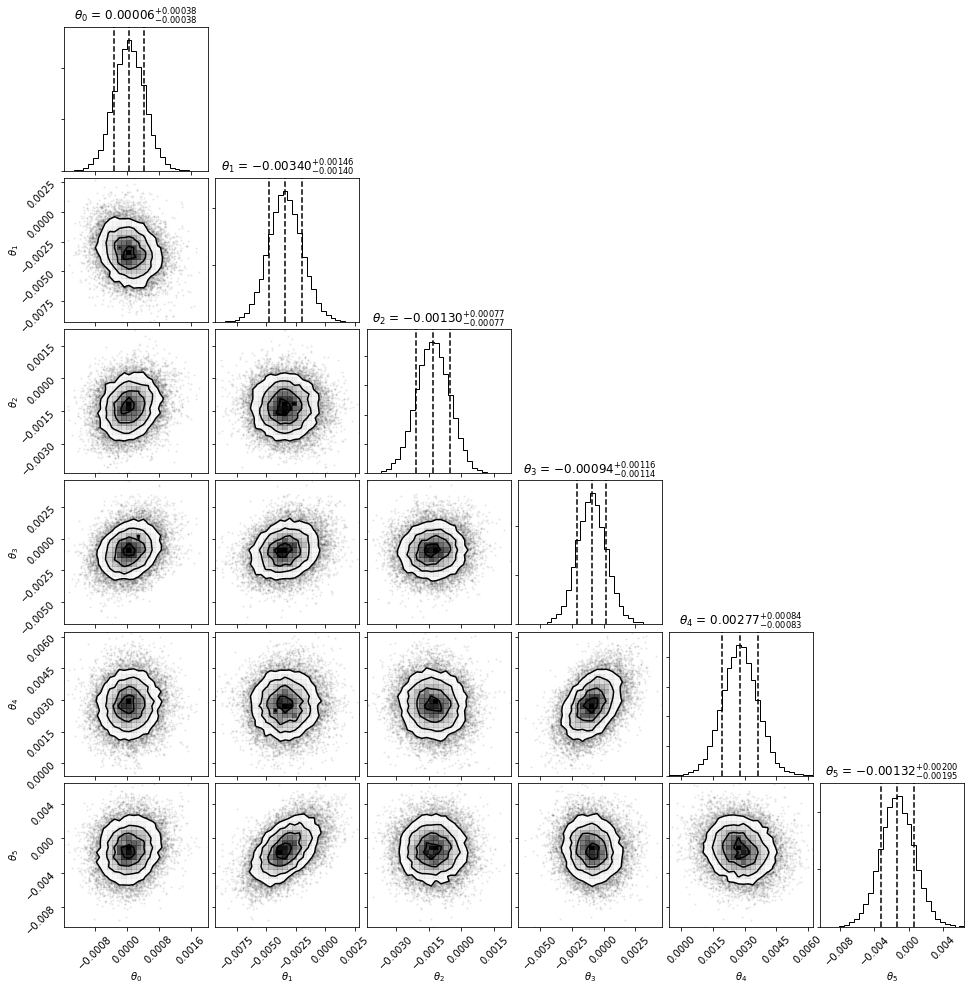

In [52]:
plt.rcParams['font.size'] = 10
param_data = ['BCG Coverage', 'Temperature', 'Relative Humidity', 
              'Tests per 1k', 'Positive Rate', 'A+ Blood Type']
param_name = [r'$\theta_0$', r'$\theta_1$', r'$\theta_2$',
              r'$\theta_3$', r'$\theta_4$', r'$\theta_5$',]
fig = corner.corner(samples['W'], labels=param_name,
                       quantiles=[0.16, 0.5, 0.84], bins=30, title_fmt='.5f',
                       show_titles=True, title_kwargs={"fontsize": 12})

# line = sns.kdeplot(samples['W'][:10,0], color='k')
# fig.legend(handles=[line for _ in range(N_theta)], 
#            labels=[f'{param_name[i]} := {param_data[i]}' for i in range(N_theta)])
plt.rcParams['font.size'] = 14

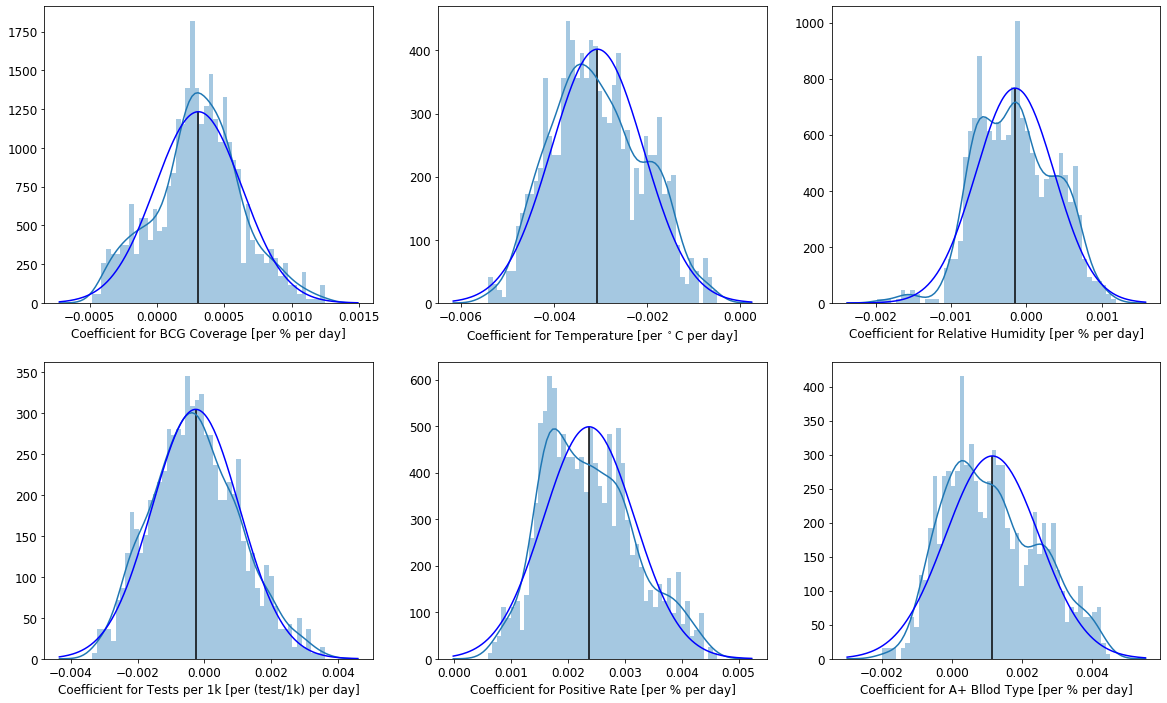

In [40]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(2, 3, figsize=(20, 12))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate', 'A+ Blood Type']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%', '%']
for i in range(N_theta):
    sns.distplot(samples['W'][:,i], bins=50, fit=norm, ax = a[i],
                 fit_kws={'color':'blue'}, color='tab:blue', label=param_name[i])
    a[i].vlines(np.mean(samples['W'][:,i]), 0, norm.pdf(np.mean(samples['W'][:,i]), *norm.fit(samples['W'][:,i])))
    a[i].set_xlabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')
plt.rcParams['font.size'] = 14

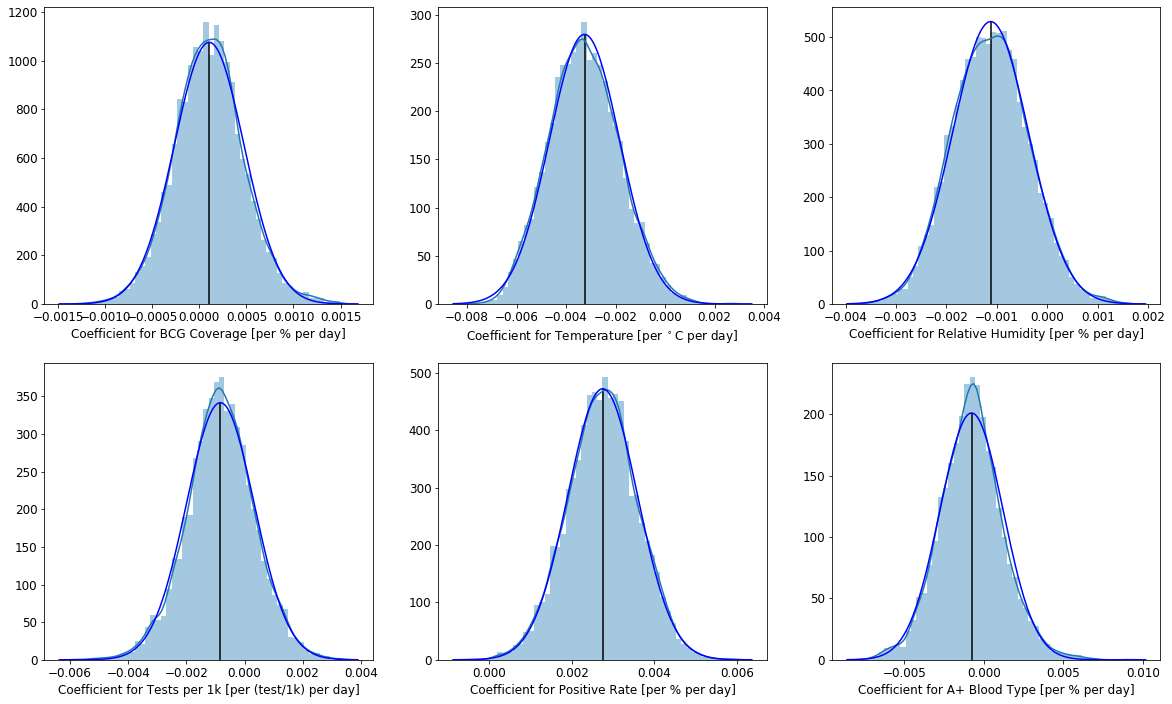

In [42]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(2, 3, figsize=(20, 12))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate', 'A+ Blood Type']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%', '%']
for i in range(N_theta):
    sns.distplot(samples['W'][good_samples,i], bins=50, fit=norm, ax = a[i],
                 fit_kws={'color':'blue'}, color='tab:blue', label=param_name[i])
    a[i].vlines(np.mean(samples['W'][good_samples,i]), 0, norm.pdf(np.mean(samples['W'][good_samples,i]), *norm.fit(samples['W'][good_samples,i])))
    a[i].set_xlabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')
plt.rcParams['font.size'] = 14

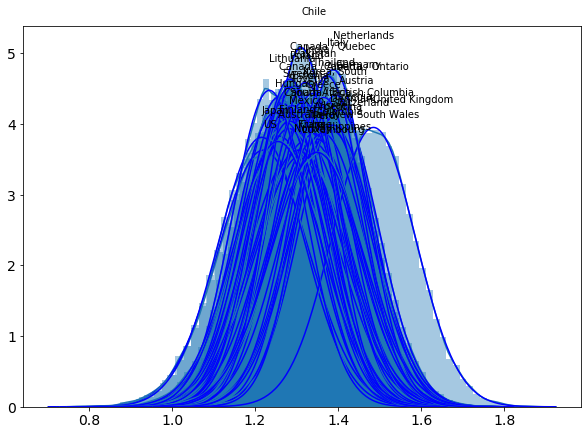

In [39]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(all_countries):
    mn = np.mean(samples['GR_ind'][:,i])
    std = np.std(samples['GR_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10, verticalalignment='center')
    sns.distplot(samples['GR_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'blue'}, color='tab:blue')

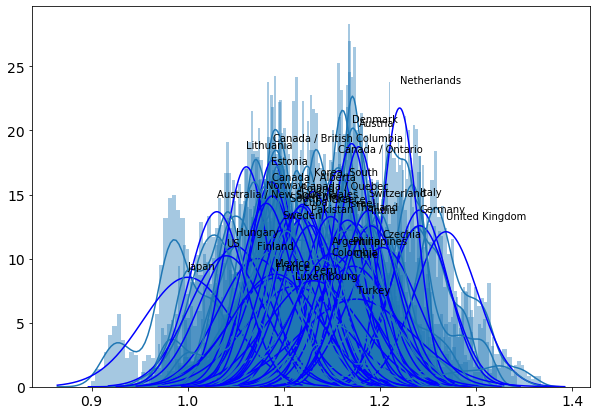

In [41]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(all_countries):
    mn = np.mean(samples['GR_ind'][:,i])
    std = np.std(samples['GR_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10, verticalalignment='center')
    sns.distplot(samples['GR_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'blue'}, color='tab:blue')

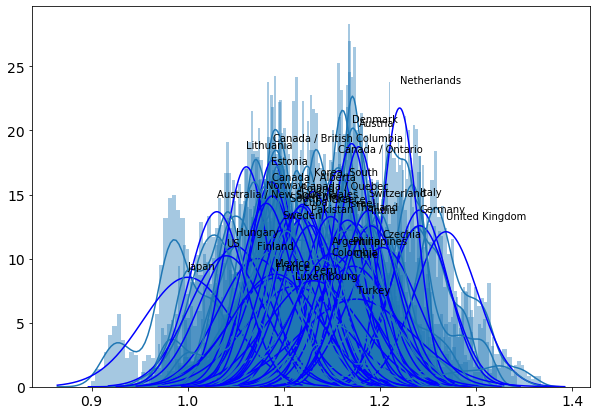

In [41]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(all_countries):
    mn = np.mean(samples['GR_ind'][:,i])
    std = np.std(samples['GR_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10, verticalalignment='center')
    sns.distplot(samples['GR_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'blue'}, color='tab:blue')

# Example Plots

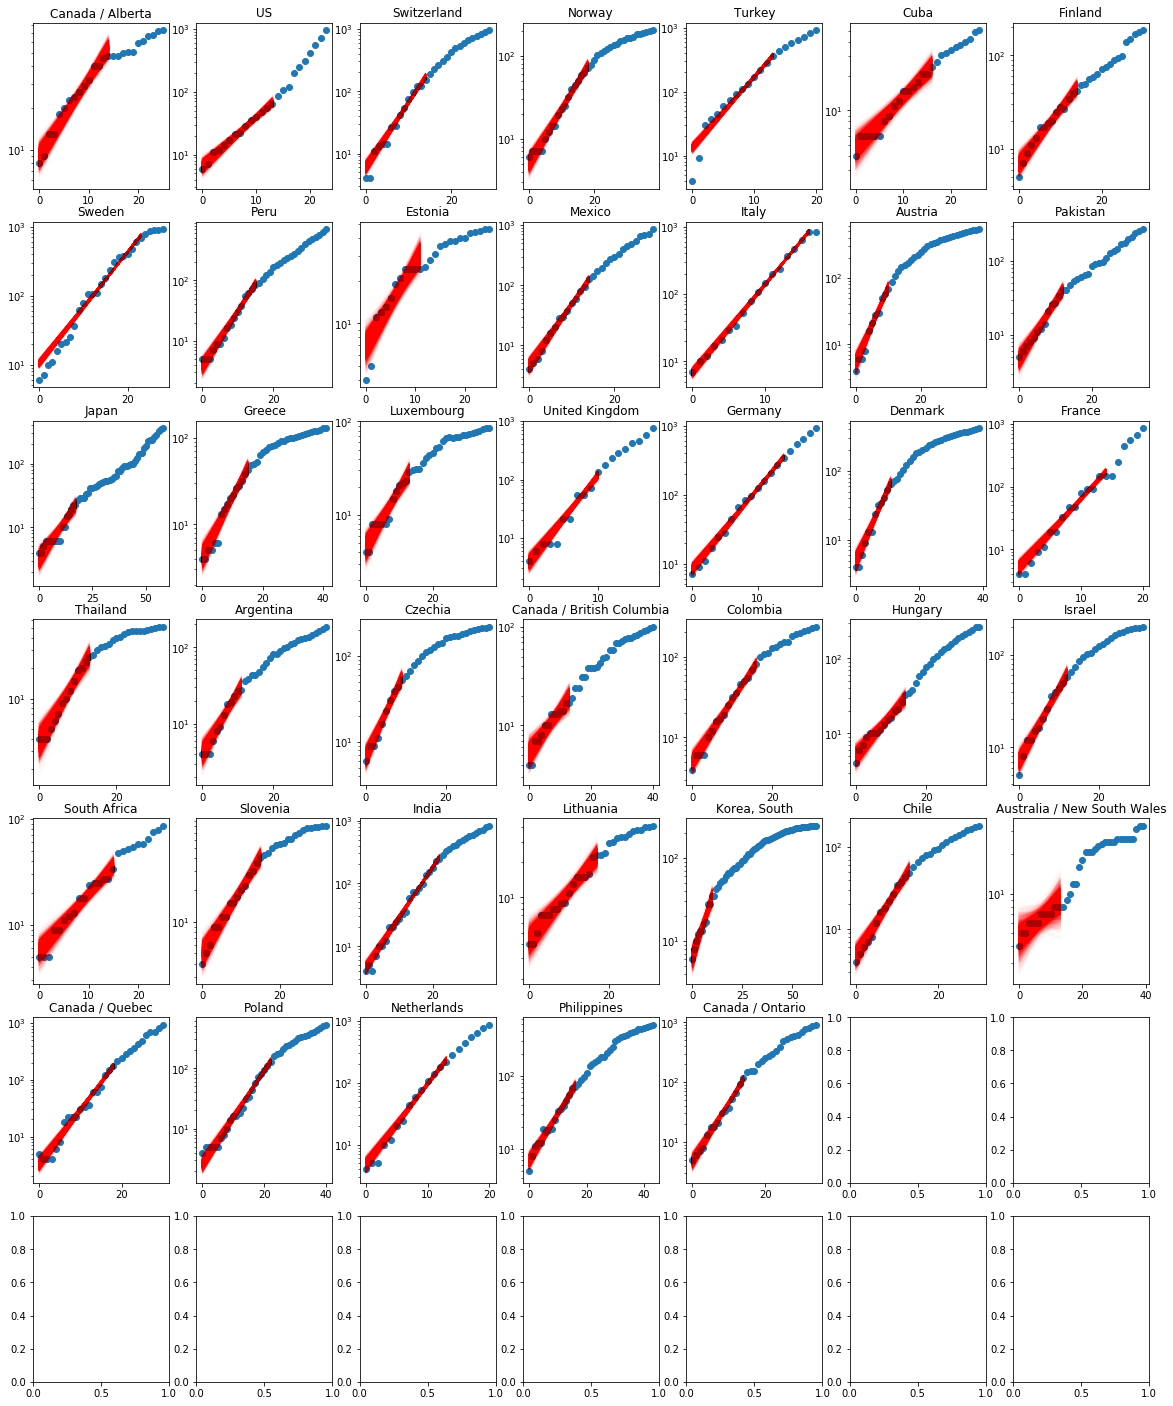

In [40]:
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(7, 7, figsize=(fig_scale*20,fig_scale*25))
a = ax.flatten()
for i, c in enumerate(all_countries):
    a[i].set_title(c)
    a[i].semilogy(deaths[c], 'o')
    dead = deaths[c]
    t = np.arange(len(dead))[:t0_dict[c]]
    correction = np.dot(samples['W'][::10,:], theta[c])[:,None]
    prediction = samples['Di_ind'][::10,i,None]*(samples['GR_ind'][::10,i,None]+correction)**t[None,:]
    a[i].semilogy(prediction.T, 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14

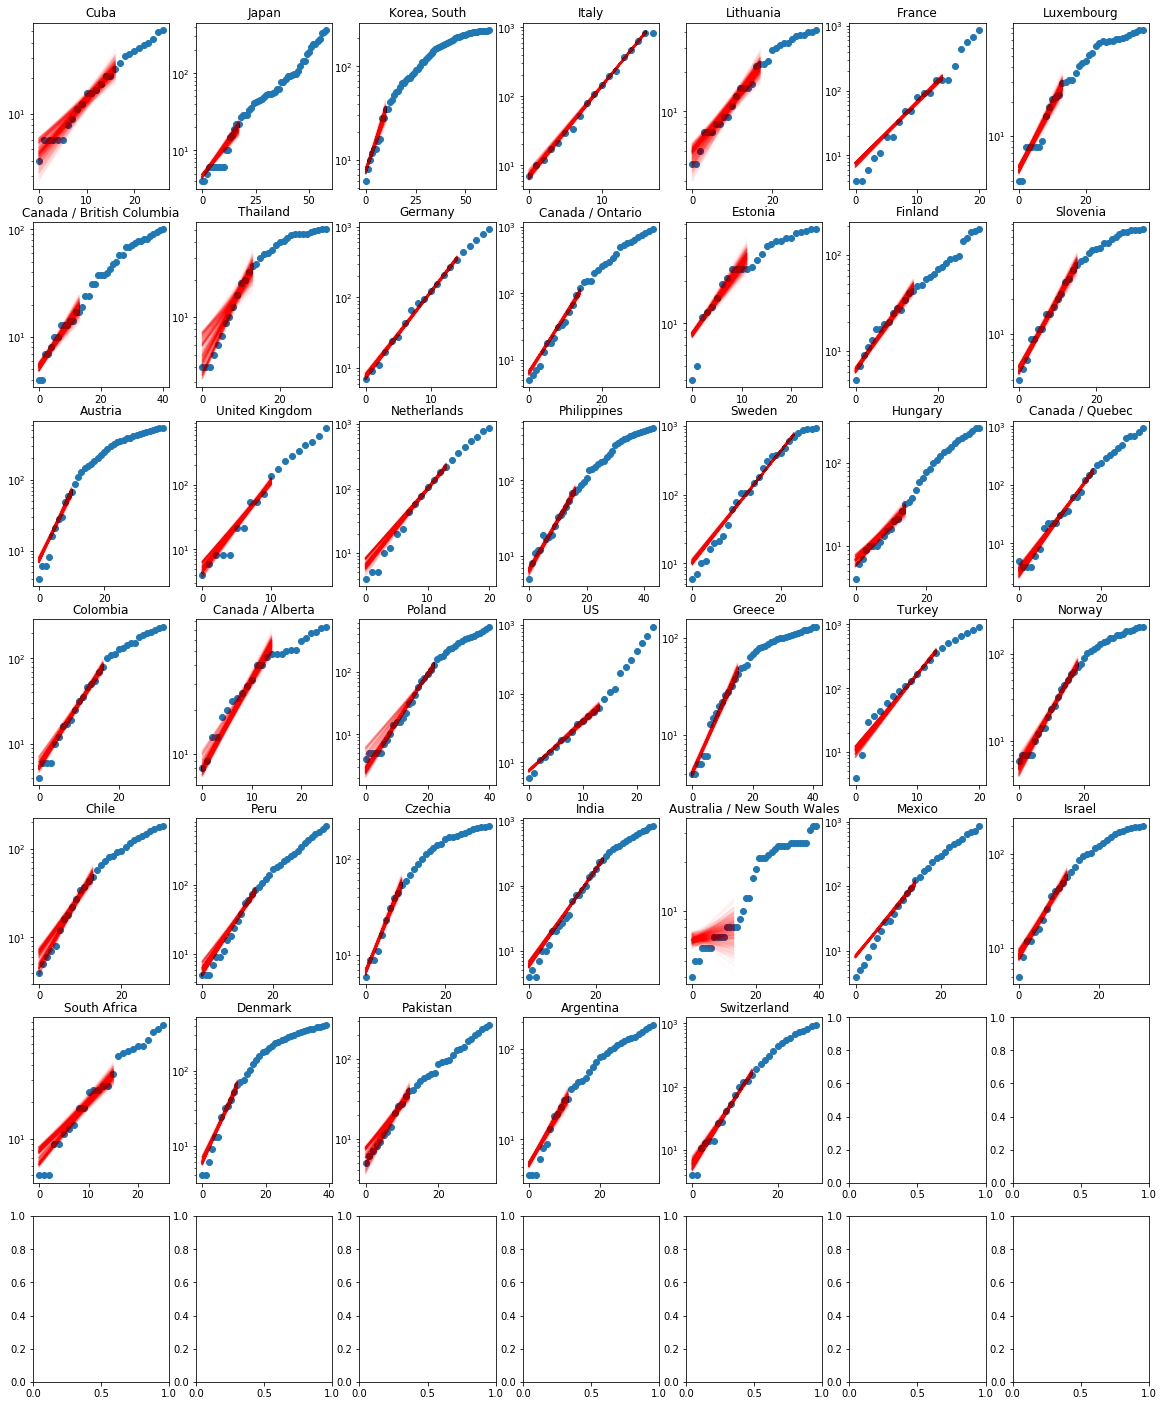

In [57]:
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(7, 7, figsize=(fig_scale*20,fig_scale*25))
a = ax.flatten()
for i, c in enumerate(all_countries):
    a[i].set_title(c)
    a[i].semilogy(deaths[c], 'o')
    dead = deaths[c]
    t = np.arange(len(dead))[:t0_dict[c]]
    correction = np.dot(samples['W'][::10,:], theta[c])[:,None]
    prediction = samples['Di_ind'][::10,i,None]*(samples['GR_ind'][::10,i,None]+correction)**t[None,:]
    a[i].semilogy(prediction.T, 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14

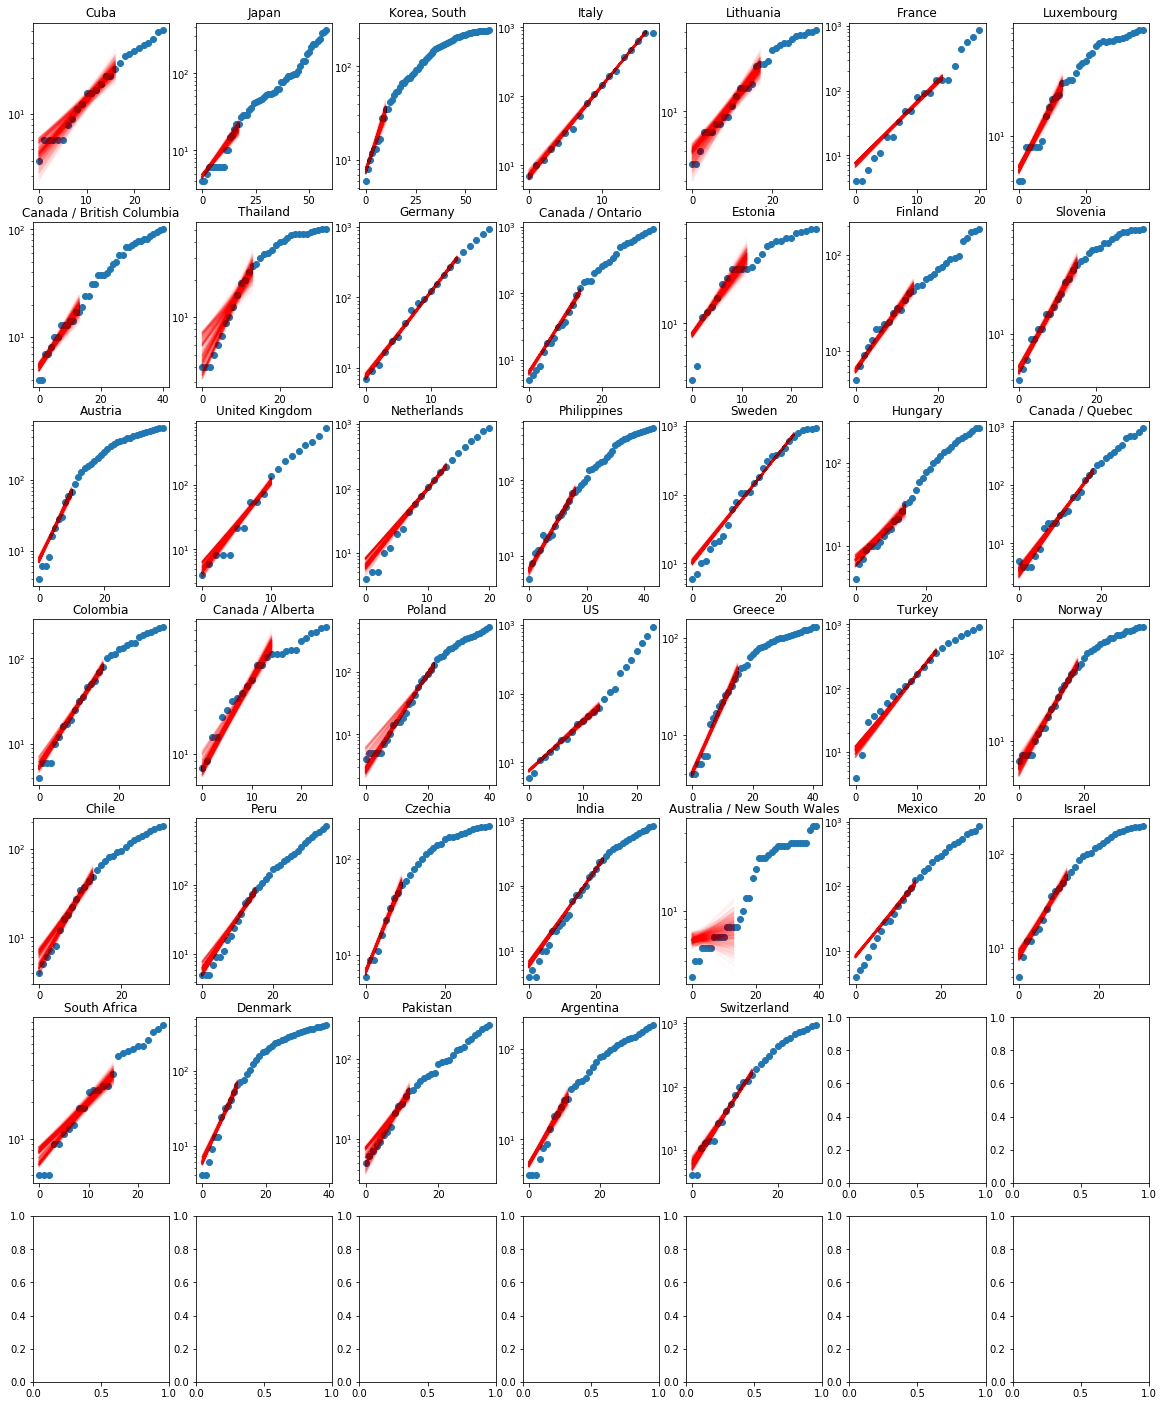

In [57]:
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(7, 7, figsize=(fig_scale*20,fig_scale*25))
a = ax.flatten()
for i, c in enumerate(all_countries):
    a[i].set_title(c)
    a[i].semilogy(deaths[c], 'o')
    dead = deaths[c]
    t = np.arange(len(dead))[:t0_dict[c]]
    correction = np.dot(samples['W'][::10,:], theta[c])[:,None]
    prediction = samples['Di_ind'][::10,i,None]*(samples['GR_ind'][::10,i,None]+correction)**t[None,:]
    a[i].semilogy(prediction.T, 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14